In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'dataset/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224,224)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'dataset/val',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(224,224)
)

# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [3]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

In [4]:
conv_base.trainable = False

In [5]:
model = Sequential()

# Base pretrained conv model
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4657s 7s/step - accuracy: 0.8511 - loss: 0.3579 - val_accuracy: 0.9126 - val_loss: 0.2081
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4858s 8s/step - accuracy: 0.9056 - loss: 0.2207 - val_accuracy: 0.9280 - val_loss: 0.1769
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4709s 8s/step - accuracy: 0.9159 - loss: 0.1956 - val_accuracy: 0.9260 - val_loss: 0.1841
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4074s 7s/step - accuracy: 0.9203 - loss: 0.1933 - val_accuracy: 0.9292 - val_loss: 0.1727
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4531s 7s/step - accuracy: 0.9206 - loss: 0.1849 - val_accuracy: 0.9310 - val_loss: 0.1699
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4141s 7s/step - accuracy: 0.9262 - loss: 0.1742 - val_accuracy: 0.9274 - val_loss: 0.1729
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4087s 7s/step - accuracy: 0.9286 - loss: 0.1679 - val_accuracy: 0.9336 - val_loss: 0.1640
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4029s 6s/step - accuracy: 0.9341 - loss: 0.1605 - 

In [8]:
# Unfreeze the last 4 convolutional layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [9]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Continue training
history_finetune = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4427s 7s/step - accuracy: 0.9460 - loss: 0.1282 - val_accuracy: 0.9512 - val_loss: 0.1222
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4418s 7s/step - accuracy: 0.9663 - loss: 0.0835 - val_accuracy: 0.9534 - val_loss: 0.1225
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4456s 7s/step - accuracy: 0.9765 - loss: 0.0652 - val_accuracy: 0.9542 - val_loss: 0.1184
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5384s 9s/step - accuracy: 0.9843 - loss: 0.0455 - val_accuracy: 0.9572 - val_loss: 0.1112
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5556s 9s/step - accuracy: 0.9895 - loss: 0.0345 - val_accuracy: 0.9596 - val_loss: 0.1159
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5002s 8s/step - accuracy: 0.9909 - loss: 0.0316 - val_accuracy: 0.9608 - val_loss: 0.1129
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4646s 7s/step - accuracy: 0.9932 - loss: 0.0229 - val_accuracy: 0.9586 - val_loss: 0.1294
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4687s 8s/step - accuracy: 0.9919 - loss: 0.0254 - 

In [16]:
model.save('model.h5')

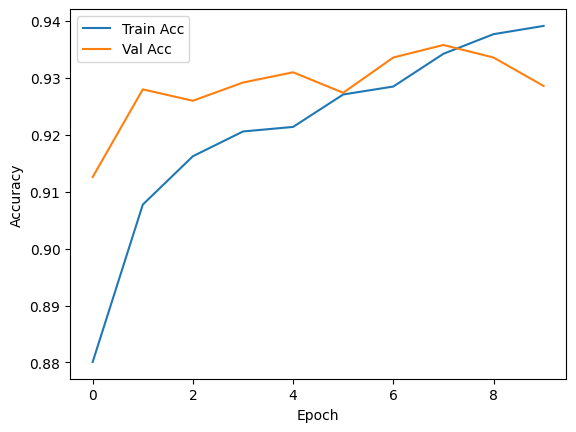

In [11]:
# 7. Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

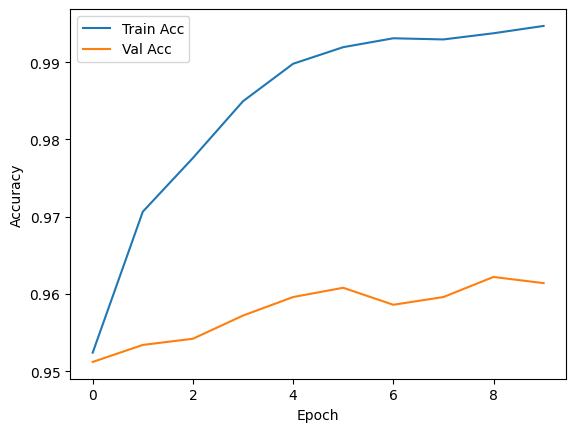

In [12]:
# 7. Plot training history
plt.plot(history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Paths
TEST_DIR = "dogs-vs-cats\\test1"   # folder containing id.jpg files
OUTPUT_CSV = "submission.csv"

# Image preprocessing parameters (must match training)
IMG_HEIGHT = 224  # change to match your training image size
IMG_WIDTH = 224
BATCH_SIZE = 32

# Function to preprocess a single image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img) / 255.0  # normalize
    return np.expand_dims(img_array, axis=0)

# List all test images
image_files = sorted(os.listdir(TEST_DIR))

ids = []
probs = []

for img_file in image_files:
    if img_file.endswith(".jpg"):
        img_id = os.path.splitext(img_file)[0]
        img_path = os.path.join(TEST_DIR, img_file)

        img_array = preprocess_image(img_path)
        prediction = model.predict(img_array, verbose=0)

        # Assuming binary classification → probability of class 1
        prob = float(prediction[0][0])

        ids.append(img_id)
        probs.append(prob)

In [26]:
# Create DataFrame
submission_df = pd.DataFrame({
    "id": ids,
    "label": probs
})

In [27]:
# Save submission
submission_df.to_csv(OUTPUT_CSV, index=False)

print(f"✅ Submission file saved at {OUTPUT_CSV}")

✅ Submission file saved at submission.csv
